In [52]:
import os.path
import os
os.chdir("../")
%run config.ipynb

import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error

In [53]:
eTraffic = pd.read_csv(os.path.join(root, 'eTraffic_lag4.csv'))
print(eTraffic.shape)
print(len(eTraffic['local_authority_name'].unique()))

(1273, 17)
67


In [54]:
eTraffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1273 entries, 0 to 1272
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   local_authority_name          1273 non-null   object 
 1   year                          1273 non-null   int64  
 2   pedal_cycles                  1273 non-null   float64
 3   two_wheeled_motor_vehicles    1273 non-null   float64
 4   cars_and_taxis                1273 non-null   float64
 5   buses_and_coaches             1273 non-null   float64
 6   LGVs                          1273 non-null   float64
 7   HGVs_2_rigid_axle             1273 non-null   float64
 8   HGVs_3_rigid_axle             1273 non-null   float64
 9   HGVs_4_or_more_rigid_axle     1273 non-null   float64
 10  HGVs_3_or_4_articulated_axle  1273 non-null   float64
 11  HGVs_5_articulated_axle       1273 non-null   float64
 12  HGVs_6_articulated_axle       1273 non-null   float64
 13  all

In [55]:
eTraffic.head()

,local_authority_name,year,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,LGVs,HGVs_2_rigid_axle,HGVs_3_rigid_axle,HGVs_4_or_more_rigid_axle,HGVs_3_or_4_articulated_axle,HGVs_5_articulated_axle,HGVs_6_articulated_axle,all_HGVs,all_motor_vehicles,GDP,local_authority_name_encoded
0,Barnet,2001,1664.0,16451.0,734298.0,11203.0,129497.0,23104.0,2428.0,3329.0,2593.0,4090.0,3151.0,38695.0,930144.0,66.5,0
1,Barnet,2002,1887.0,17509.0,813092.0,12809.0,143238.0,25830.0,3132.0,3590.0,2794.0,4420.0,3878.0,43644.0,1030292.0,68.5,0
2,Barnet,2003,1328.0,13962.0,732845.0,9997.0,114664.0,21243.0,2853.0,3791.0,1977.0,3934.0,3257.0,37055.0,908523.0,70.1,0
3,Barnet,2004,1712.0,12403.0,617142.0,10739.0,100724.0,14398.0,2222.0,3278.0,1767.0,2666.0,2182.0,26513.0,767521.0,71.4,0
4,Barnet,2005,1443.0,12398.0,576669.0,9097.0,100885.0,15491.0,2760.0,2782.0,1798.0,3425.0,2956.0,29212.0,728261.0,73.9,0


## Select Feature and Model

In [56]:
eTraffic = eTraffic[eTraffic['year'] < 2020]
print(eTraffic['year'].min(), eTraffic['year'].max())
print(eTraffic.shape)

2001 2019
(1273, 17)


In [57]:
X = eTraffic.drop(columns=['GDP', 'year', 'local_authority_name', 'local_authority_name_encoded'])
y = eTraffic['GDP']
print(X.shape, y.shape)

(1273, 13) (1273,)


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

In [59]:
param_dist = {
    'n_estimators': np.arange(20, 100, step=5),
    'max_depth': np.arange(3, 12, step=1),
    'min_samples_split': np.arange(3, 12, step=1),
    'min_samples_leaf': np.arange(2, 12, step=1),
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=18)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, cv=3, scoring='r2', random_state=18)
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'n_estimators': 90, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 11, 'bootstrap': True}
Best score: 0.5172975320440365


In [60]:
# train set
Y_train_hat = random_search.best_estimator_.predict(X_train)
mse_train = mean_squared_error(y_train, Y_train_hat)
mae_train = mean_absolute_error(y_train, Y_train_hat)
mape_train = mean_absolute_percentage_error(y_train, Y_train_hat)
r2_train = r2_score(y_train, Y_train_hat)

# test set
Y_test_hat = random_search.best_estimator_.predict(X_test)
mse_test = mean_squared_error(y_test, Y_test_hat)
mae_test = mean_absolute_error(y_test, Y_test_hat)
mape_test = mean_absolute_percentage_error(y_test, Y_test_hat)
r2_test = r2_score(y_test, Y_test_hat)

print(f"[RF][Training Set] MSE: {mse_train:.2f}; MAPE: {mape_train:.2f}; MAE: {mae_train:.2f}; R2 score: {r2_train:.2f}")
print(f"[RF][Testing Set]  MSE: {mse_test:.2f}; MAPE: {mape_test:.2f}; MAE: {mae_test:.2f}; R2 score: {r2_test:.2f}")

feature_importances = random_search.best_estimator_.feature_importances_

features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

features_df

[RF][Training Set] MSE: 23.19; MAPE: 0.04; MAE: 3.21; R2 score: 0.80
[RF][Testing Set]  MSE: 65.68; MAPE: 0.07; MAE: 5.71; R2 score: 0.51


,Feature,Importance
8,HGVs_3_or_4_articulated_axle,0.252344
10,HGVs_6_articulated_axle,0.221591
5,HGVs_2_rigid_axle,0.147968
7,HGVs_4_or_more_rigid_axle,0.076870
4,LGVs,0.061604
3,buses_and_coaches,0.053787
1,two_wheeled_motor_vehicles,0.042952
0,pedal_cycles,0.037144
6,HGVs_3_rigid_axle,0.031770
9,HGVs_5_articulated_axle,0.031554


### Select features with cumulative importance in the top 85%

In [61]:
features_df['Cumulative Importance'] = features_df['Importance'].cumsum()

selected_features = features_df[features_df['Cumulative Importance'] <= 0.85]['Feature']
print(f"Selected Features number: {len(selected_features)}")
print(f"Selected Features: \n{selected_features}")

Selected Features number: 6
Selected Features: 
8     HGVs_3_or_4_articulated_axle
10         HGVs_6_articulated_axle
5                HGVs_2_rigid_axle
7        HGVs_4_or_more_rigid_axle
4                             LGVs
3                buses_and_coaches
Name: Feature, dtype: object


## Retrain the model using selected features

In [62]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(X_train_selected.shape, X_test_selected.shape)
print(X_train_selected.columns)

(1018, 6) (255, 6)
Index(['HGVs_3_or_4_articulated_axle', 'HGVs_6_articulated_axle',
       'HGVs_2_rigid_axle', 'HGVs_4_or_more_rigid_axle', 'LGVs',
       'buses_and_coaches'],
      dtype='object')


In [63]:
# modeling
param_dist = {
    'n_estimators': np.arange(20, 80, step=5),
    'max_depth': np.arange(3, 10, step=1),
    'min_samples_split': np.arange(3, 10, step=1),
    'min_samples_leaf': np.arange(2, 10, step=1),
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=18)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, cv=3, scoring='r2', random_state=18)
random_search.fit(X_train_selected, y_train)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

rf_best = random_search.best_estimator_

# test set
Y_test_hat = rf_best.predict(X_test_selected)
mse_test = mean_squared_error(y_test, Y_test_hat)
mae_test = mean_absolute_error(y_test, Y_test_hat)
mape_test = mean_absolute_percentage_error(y_test, Y_test_hat)
r2_test = r2_score(y_test, Y_test_hat)

# train set
Y_train_hat = rf_best.predict(X_train_selected)
mse_train = mean_squared_error(y_train, Y_train_hat)
mae_train = mean_absolute_error(y_train, Y_train_hat)
mape_train = mean_absolute_percentage_error(y_train, Y_train_hat)
r2_train = r2_score(y_train, Y_train_hat)

print(f"[RF][Training Set] MSE: {mse_train:.2f}; MAPE: {mape_train:.2f}; MAE: {mae_train:.2f}; R2 score: {r2_train:.2f}")
print(f"[RF][Testing Set]  MSE: {mse_test:.2f}; MAPE: {mape_test:.2f}; MAE: {mae_test:.2f}; R2 score: {r2_test:.2f}")

Best parameters: {'n_estimators': 40, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_depth': 9, 'bootstrap': True}
Best score: 0.5061773993850908
[RF][Training Set] MSE: 20.07; MAPE: 0.04; MAE: 3.15; R2 score: 0.83
[RF][Testing Set]  MSE: 70.38; MAPE: 0.07; MAE: 5.80; R2 score: 0.47


### Grid search in a small range base on privous parameters

In [64]:
best_model = random_search.best_params_
# param_grid = {
#     'n_estimators': np.arange(-10, 10, step=3) + best_model['n_estimators'],  # 树的数量
#     'max_depth': np.arange(-2, 2, step=3) + best_model['max_depth'],  # 树的最大深度
#     'min_samples_split': np.arange(2, 4, step=2) + best_model['min_samples_leaf'],  # 节点分裂所需的最小样本数
#     'min_samples_leaf': np.arange(2, 4, step=2) + best_model['min_samples_leaf'],
#     'bootstrap': [best_model['bootstrap']]
# }

param_grid = {
    'n_estimators': [8, 12, 17],
    'max_depth': [4, 6, 8],
    'min_samples_split': [18, 20, 22],
    'min_samples_leaf': [16, 20, 22],
    'bootstrap': [True]
}

rf = RandomForestRegressor(random_state=18)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, scoring='r2')
grid_search.fit(X_train_selected, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# train set
Y_train_hat = grid_search.best_estimator_.predict(X_train_selected)
mse_train = mean_squared_error(y_train, Y_train_hat)
mae_train = mean_absolute_error(y_train, Y_train_hat)
mape_train = mean_absolute_percentage_error(y_train, Y_train_hat)
r2_train = r2_score(y_train, Y_train_hat)

# test set
Y_test_hat = grid_search.best_estimator_.predict(X_test_selected)
mse_test = mean_squared_error(y_test, Y_test_hat)
mae_test = mean_absolute_error(y_test, Y_test_hat)
mape_test = mean_absolute_percentage_error(y_test, Y_test_hat)
r2_test = r2_score(y_test, Y_test_hat)

print(f"[RF][Training Set] MSE: {mse_train:.2f}; MAPE: {mape_train:.2f}; MAE: {mae_train:.2f}; R2 score: {r2_train:.2f}")
print(f"[RF][Testing Set]  MSE: {mse_test:.2f}; MAPE: {mape_test:.2f}; MAE: {mae_test:.2f}; R2 score: {r2_test:.2f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=16, min_samples_split=18, n_estimators=8; total time=   0.0s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=16, min_samples_split=18, n_estimators=8; total time=   0.0s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=16, min_samples_split=18, n_estimators=8; total time=   0.0s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=16, min_samples_split=18, n_estimators=8; total time=   0.0s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=16, min_samples_split=18, n_estimators=8; total time=   0.0s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=16, min_samples_split=18, n_estimators=12; total time=   0.0s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=16, min_samples_split=18, n_estimators=12; total time=   0.0s
[CV] END bootstrap=True, max_depth=4, min_samples_leaf=16, min_samples_split=18, n_estimators=12; total time=   0.0s
[CV] EN

In [65]:
feature_importances = grid_search.best_estimator_.feature_importances_
print(feature_importances.shape)
print(X_train_selected.shape)
features_df = pd.DataFrame({
    'Feature': X_train_selected.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

features_df

(6,)
(1018, 6)


,Feature,Importance
0,HGVs_3_or_4_articulated_axle,0.297336
1,HGVs_6_articulated_axle,0.282686
2,HGVs_2_rigid_axle,0.221868
4,LGVs,0.068813
3,HGVs_4_or_more_rigid_axle,0.068036
5,buses_and_coaches,0.061261


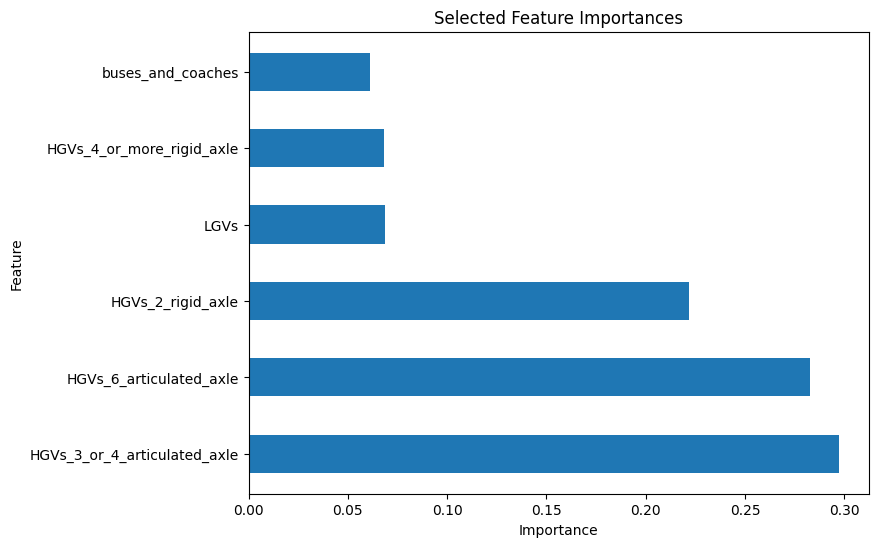

In [66]:
# plot importance of features
plt.figure(figsize=(8, 6))
plt.bar(x=0, bottom=features_df['Feature'],
        height=0.5, width=features_df['Importance'], orientation='horizontal')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Selected Feature Importances')
plt.show()

As we have found the important features:
- HGVs_3_or_4_articulated_axle
- HGVs_6_articulated_axle
- LGVs
- HGVs_2_rigid_axle
- HGVs_4_or_more_rigid_axle
